<a href="https://colab.research.google.com/github/pietoli/cnn_malaria_detection/blob/master/Malaria_basic_cnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading modules

In [1]:
import os
import glob
from collections import Counter
from concurrent import futures
import threading
import datetime

import cv2

import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

from keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
from keras import layers, models, optimizers
from keras.models import load_model

import tensorflow as tf

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score,f1_score, classification_report, confusion_matrix


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


# Setting up Google Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# CONFIGS

In [4]:
experiment_name = 'test_malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator'
#experiment_name = 'modelsmalaria_basic_cnn_30_epochs_without_dropout'
dataset_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/dataset"
models_dir =  "/content/drive/My Drive/Colab Notebooks/Malaria/models"
weights_dir =  "/content/drive/My Drive/Colab Notebooks/Malaria/weights"
classification_reports_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/reports"
plots_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/plots"
confusion_dir = "/content/drive/My Drive/Colab Notebooks/Malaria/confusion matrix"

# Loading data

In [5]:
# Ścieżki do folderów ze zdjęciami
infected_dir = os.path.join(dataset_dir,'Parasitized')
healthy_dir = os.path.join(dataset_dir,'Uninfected')

# Rozpakowanie plików
infected_files = glob.glob(infected_dir+'/*.png')
healthy_files = glob.glob(healthy_dir+'/*.png')
len(infected_files), len(healthy_files)

(13779, 13779)

In [6]:
np.random.seed(42)

# Utworzenie dataframe'u z plikami
files_df = pd.DataFrame({
    'filename': infected_files + healthy_files,
    'label': ['infected'] * len(infected_files) + ['uninfected'] * len(healthy_files)
}).sample(frac=1, random_state=42).reset_index(drop=True) #frac=1 oznacza, że zwrócone zostaną wszystkie wiersze w randomowej kolejności

files_df.head()

,filename,label
0,/content/drive/My Drive/Colab Notebooks/Malari...,infected
1,/content/drive/My Drive/Colab Notebooks/Malari...,infected
2,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected
3,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected
4,/content/drive/My Drive/Colab Notebooks/Malari...,uninfected


## Getting the size of images

In [8]:
width = []
height = []
for f in files_df['filename']:
    shape = cv2.imread(f).shape
    width.append(shape[0])
    height.append(shape[1])
  
print("The average image size is ({0},{1})".format(np.mean(width), np.mean(height)))    
print("The median image size is ({0},{1})".format(np.median(width), np.median(height)))


The average image size is (132.9834530807751,132.48715436533857)
The median image size is (130.0,130.0)


## Showing images examples

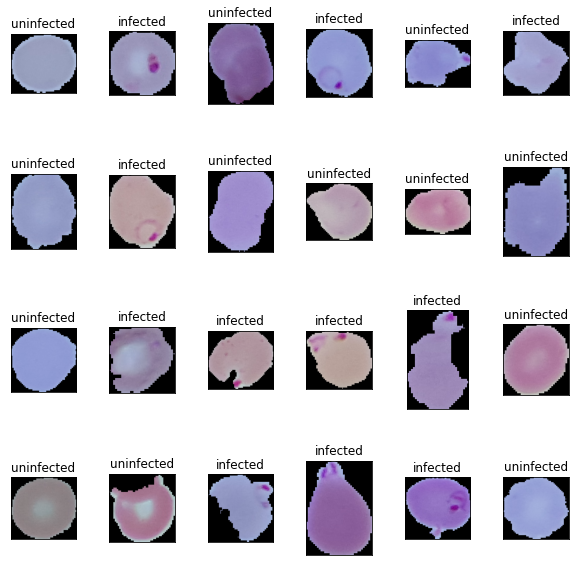

In [9]:
rows = 4
columns = 6
fig = plt.figure(1, figsize=(10,10))


for i in range(1, rows*columns +1):
    r = np.random.randint(1, len(files_df['filename']))
    img = cv2.imread(files_df['filename'].iloc[r])
    fig.add_subplot(rows,columns,i)
    plt.subplots_adjust(hspace = 0.5 , wspace = 0.5)
    plt.imshow(img/255.)
    plt.xticks([]) , plt.yticks([])
    plt.title(files_df['label'].iloc[r])
    #plt.savefig('/content/drive/My Drive/Colab Notebooks/Malaria/malaria_example.png', bbox_inches='tight')  
plt.show()




# Dividing dataset into test, validation and training set

Ratio 60:20:20

In [10]:

train_files, test_files, train_labels, test_labels = train_test_split(files_df['filename'].values,
                                                                      files_df['label'].values, 
                                                                      test_size=5512,
                                                                      random_state=42,
                                                                      stratify=files_df['label'].values)
train_files, val_files, train_labels, val_labels = train_test_split(train_files,
                                                                    train_labels, 
                                                                    test_size=5512,
                                                                    random_state=42,
                                                                    stratify=train_labels)


print('Number of train data: {0}, where {1} are infected and {2} uninfected.'.format(len(train_labels),Counter(train_labels)['infected'],Counter(train_labels)['uninfected']), 
      '\nNumber of validation data: {0}, where {1} are infected and {2} uninfected.'.format(len(val_labels),Counter(val_labels)['infected'],Counter(val_labels)['uninfected']), 
      '\nNumber of test data: {0}, where {1} are infected and {2} uninfected.'.format(len(test_labels),Counter(test_labels)['infected'],Counter(test_labels)['uninfected']))

Number of train data: 16534, where 8267 are infected and 8267 uninfected. 
Number of validation data: 5512, where 2756 are infected and 2756 uninfected. 
Number of test data: 5512, where 2756 are infected and 2756 uninfected.


# Data preprocessing

## Changing image size

In [11]:
def process_train_files(width, height):
  train_data = []
  i = 0
  for f in train_files:
    #print(i)
    image = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC)
    train_data.append(image)
    i += 1
  return np.array(train_data)

def process_test_files(width, height):
  test_data = []
  i = 0
  for f in test_files:
    #print(i)
    image = cv2.imread(f, cv2.IMREAD_COLOR)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC )
    test_data.append(image)
    i += 1
  return np.array(test_data)

def process_val_files(width, height):
  val_data = []
  i = 0
  for f in val_files:
    #print(i)
    image = cv2.imread(f, cv2.IMREAD_UNCHANGED)
    image = cv2.resize(image, (width, height),interpolation=cv2.INTER_CUBIC)
    val_data.append(image)
    i += 1
  return np.array(val_data)


In [12]:
train_data = process_train_files(150, 150)
val_data = process_val_files(150,150)
test_data = process_test_files(150,150)

## Scaling

In [13]:
# Scaling train and validation set 
train_imgs_scaled = train_data / 255.
val_imgs_scaled = val_data / 255.

## Label encoding

In [14]:
# 1 for infected and 0 for uninfected
le = LabelEncoder()
le.fit(train_labels)
train_labels_enc = le.transform(train_labels)
val_labels_enc = le.transform(val_labels)

print(train_labels[:6], train_labels_enc[:6])

['uninfected' 'infected' 'uninfected' 'infected' 'infected' 'uninfected'] [1 0 1 0 0 1]


# Customized model architecture

In [15]:
model = models.Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150,150,3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
#model.add(layers.Dropout(0.3))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 15, 15, 128)      

## Defining optimizer

In [16]:
from keras.optimizers import Adam
model.compile(optimizer=Adam(lr=1e-4), loss='binary_crossentropy', metrics=['accuracy'])           

#  Model training

In [17]:
#early stopping
es = EarlyStopping(monitor='val_accuracy', mode='auto', verbose=1, patience=5)
#checkpoint
cp_filepath= experiment_name+"-weights-best.hdf5"
checkpoint = ModelCheckpoint(cp_filepath, monitor='val_accuracy', verbose=1,
                             save_best_only=True, mode='max')
#csvlogger
log_filepath = experiment_name+'log.csv'
csvlogger = CSVLogger(log_filepath, append=False, separator=';')

callbacks_list = [checkpoint, es, csvlogger]

history = model.fit(x=train_imgs_scaled, y=train_labels_enc, 
                    batch_size=64,
                    epochs=100, 
                    validation_data=(val_imgs_scaled, val_labels_enc), 
                    verbose=1,
                    callbacks=callbacks_list)

Train on 16534 samples, validate on 5512 samples
Epoch 1/100
16534/16534 [==============================] - 21s 1ms/step - loss: 0.5481 - accuracy: 0.7166 - val_loss: 0.3567 - val_accuracy: 0.8233

Epoch 00001: val_accuracy improved from -inf to 0.82329, saving model to test_malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator-weights-best.hdf5
Epoch 2/100
16534/16534 [==============================] - 14s 859us/step - loss: 0.2197 - accuracy: 0.9187 - val_loss: 0.1693 - val_accuracy: 0.9461

Epoch 00002: val_accuracy improved from 0.82329 to 0.94612, saving model to test_malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator-weights-best.hdf5
Epoch 3/100
16534/16534 [==============================] - 14s 865us/step - loss: 0.1730 - accuracy: 0.9436 - val_loss: 0.1581 - val_accuracy: 0.9476

Epoch 00003: val_accuracy improved from 0.94612 to 0.94757, saving model to test_malaria_basic_cnn_50_epochs_with_dropout_adam_optimalizator-weights-best.hdf5
Epoch 4/100
16534/16534 [=

## Saving model and weights

In [18]:
model.save(models_dir+ '/' + experiment_name +'.h5')
model.save_weights(weights_dir + '/' + experiment_name +'_weights.h5')

# Plots

In [19]:
def make_accuracy_plot(history, plot_dir, experiment_name):
    acc, val_acc = history.history['accuracy'], history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(10, 8))
    plt.plot(epochs, acc, label='Training accuracy', marker='o')
    plt.plot(epochs, val_acc, label='Validation accuracy', marker='o')
    plt.legend()
    plt.title('Trainig and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    save_path = plots_dir + '/' + experiment_name + '_accuracy_plot.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

def make_loss_plot(history, plot_dir, experiment_name):
    loss, val_loss = history.history['loss'], history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    
    plt.figure(figsize=(10, 8))
    plt.plot(epochs, loss, label='Training loss', marker='o')
    plt.plot(epochs, val_loss, label='Validation loss', marker='o')
    plt.legend()
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    save_path = plots_dir + '/' + experiment_name + '_loss_plot.png'
    plt.savefig(save_path, bbox_inches='tight')
    plt.show()

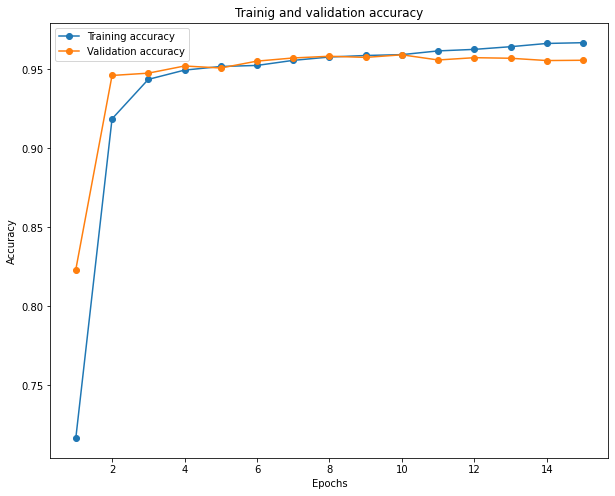

In [20]:
make_accuracy_plot(history, plots_dir, experiment_name)

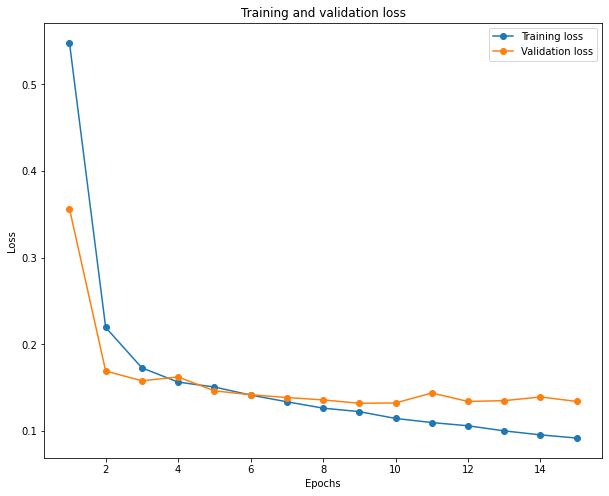

In [21]:
make_loss_plot(history, plots_dir, experiment_name)

# Predictions

In [ ]:
#model = load_model(models_dir+ '/' + experiment_name +'.h5')

In [22]:
# Scaling test set
test_imgs_scaled = test_data / 255.
test_imgs_scaled.shape, test_labels.shape

((5512, 150, 150, 3), (5512,))

In [23]:
basic_cnn_preds = model.predict(test_imgs_scaled)

In [24]:
basic_cnn_pred_labels = le.inverse_transform([1 if pred > 0.5 else 0 for pred in basic_cnn_preds.ravel()])

## Confusion matrix

In [25]:
cm = confusion_matrix(y_true=test_labels, y_pred=basic_cnn_pred_labels)

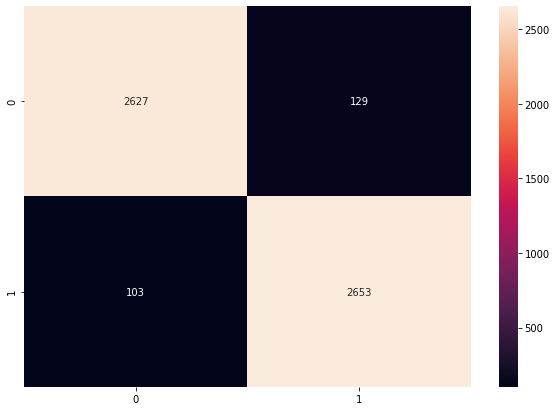

In [26]:
plt.figure(figsize=(10,7))
heatmap = sn.heatmap(cm, annot=True, fmt="d")
plt.show(heatmap)

fig = heatmap.get_figure()
fig.savefig(confusion_dir+'/' + experiment_name + '.png')

## Classification report

In [29]:
report = classification_report(test_labels, basic_cnn_pred_labels, target_names=['infected', 'uninfected'], output_dict=True)
df = pd.DataFrame(report).transpose()
report_name = classification_reports_dir + '/' +experiment_name + '.csv'
df.to_csv(report_name,sep='\t')
df

,precision,recall,f1-score,support
infected,0.962271,0.953193,0.957711,2756.00000
uninfected,0.953630,0.962627,0.958108,2756.00000
accuracy,0.957910,0.957910,0.957910,0.95791
macro avg,0.957951,0.957910,0.957909,5512.00000
weighted avg,0.957951,0.957910,0.957909,5512.00000
